# A simple code-graded evaluation

In this lesson we'll start with a look at a very simple example code-graded evaluation, before covering a more realistic prompt in the next lesson.  We'll follow the process outlined in this diagram:

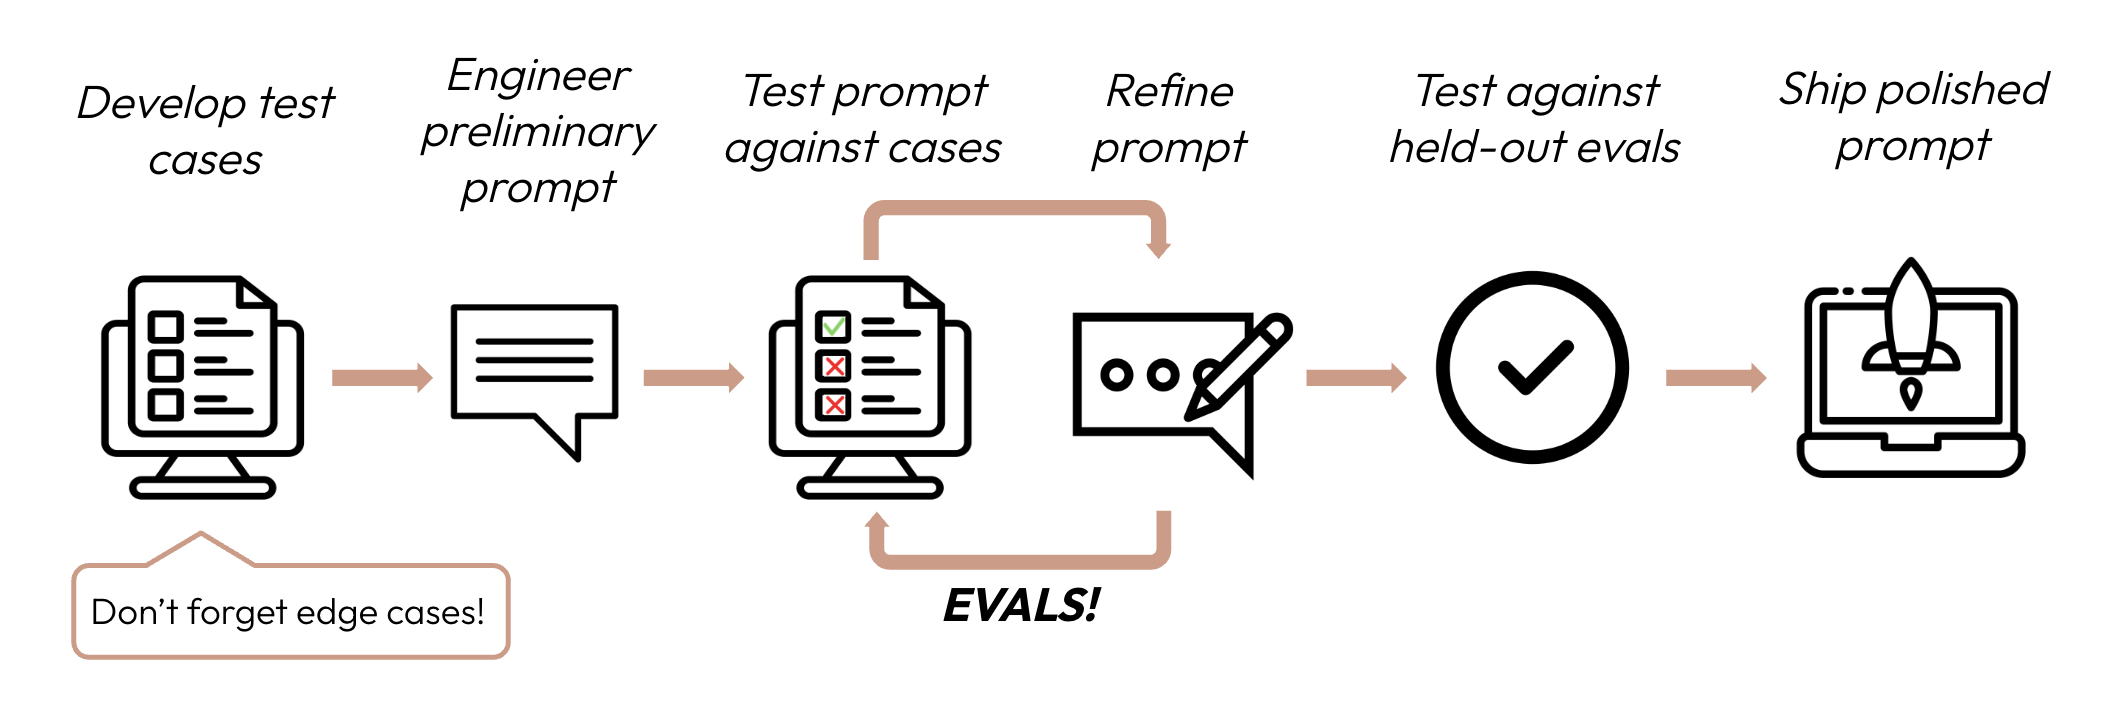

The rough steps are:
1. Start by defining our evaluation test set
1. Write our initial prompt attempt
2. Run it through our evaluation process and get a score
3. Alter our prompt based on the evaluation results
4. Run the altered prompt through our evaluation process and hopefully get a better score!

Let's try following this process!

---

## Our input data

We'll be grading an eval where we ask Claude to successfully identify how many legs an animal has.  In future lessons we'll see more complex and realistic prompts and evaluations, but we're keeping things deliberately simple here to focus on the actual evaluation process.

The first step is to write our evaluation data set that includes our inputs plus corresponding golden answers.  Let's use this simple list of dictionaries, where each dictionary has an `animal_statement` and `golden_answer` key:

In [1]:
eval_data = [
    {"animal_statement": "The animal is a human.", "golden_answer": "2"},
    {"animal_statement": "The animal is a snake.", "golden_answer": "0"},
    {"animal_statement": "The fox lost a leg, but then magically grew back the leg he lost and a mysterious extra leg on top of that.", "golden_answer": "5"},
    {"animal_statement": "The animal is a dog.", "golden_answer": "4"},
    {"animal_statement": "The animal is a cat with two extra legs.", "golden_answer": "6"},
    {"animal_statement": "The animal is an elephant.", "golden_answer": "4"},
    {"animal_statement": "The animal is a bird.", "golden_answer": "2"},
    {"animal_statement": "The animal is a fish.", "golden_answer": "0"},
    {"animal_statement": "The animal is a spider with two extra legs", "golden_answer": "10"},
    {"animal_statement": "The animal is an octopus.", "golden_answer": "8"},
    {"animal_statement": "The animal is an octopus that lost two legs and then regrew three legs.", "golden_answer": "9"},
    {"animal_statement": "The animal is a two-headed, eight-legged mythical creature.", "golden_answer": "8"},
]

Notice that some of the evaluation questions are a little bit tricky, like this one: 
> The fox lost a leg, but then magically grew back the leg he lost and a mysterious extra leg on top of that.

This will be important later!

---

## Our initial prompt
Next, we'll define out initial prompt.  The function below takes in a single animal statement and returns a properly formatted messages list containing our first prompt attempt:

In [2]:
def build_input_prompt(animal_statement):
    user_content = f"""You will be provided a statement about an animal and your job is to determine how many legs that animal has.
    
    Here is the animal statement.
    <animal_statement>{animal_statement}</animal_statement>
    
    How many legs does the animal have? Please respond with a number"""

    messages = [{'role': 'user', 'content': user_content}]
    return messages

Let's test it out quickly with the first element in our `eval` dataset:

In [3]:
build_input_prompt(eval_data[0]['animal_statement'])

[{'role': 'user',
  'content': 'You will be provided a statement about an animal and your job is to determine how many legs that animal has.\n    \n    Here is the animal statement.\n    <animal_statement>The animal is a human.</animal_statement>\n    \n    How many legs does the animal have? Please respond with a number'}]

Next, we'll write a simple function that takes a list of messages and send it off to the Anthropic API:

In [5]:
from anthropic import Anthropic
from dotenv import load_dotenv

load_dotenv()
client = Anthropic()

MODEL_NAME = "claude-3-haiku-20240307"

def get_completion(messages):
    response = client.messages.create(
        model=MODEL_NAME,
        max_tokens=200,
        messages=messages
    )
    return response.content[0].text

Let's test it out with out first entry in the `eval_data` list, which contains the following animal statement: 
```
'The animal is a human.'
```

In [6]:
full_prompt = build_input_prompt(eval_data[0]['animal_statement'])
get_completion(full_prompt)

'2'

We get `2` back as the response, which passes the eyeball test! Humans generally have two legs. The next step is to build and run an entire evaluation with all 12 entries in our `eval_data` set.

---

## Writing the eval logic

We'll start by combing each input from our `eval_data` list with our prompt template, passing the resulting "finished" prompts to the model, and collecting all the outputs we get back:

In [93]:

outputs = [get_completion(build_input_prompt(question['animal_statement'])) for question in eval_data]


Let's take a quick peek at what we get back:

In [94]:
outputs

['2',
 '0',
 '5',
 '4',
 '6',
 '4',
 'Based on the provided animal statement, "The animal is a bird.", the animal has 2 legs.\n\nResponse: 2',
 '0',
 '8',
 'An octopus has 8 legs.',
 '5',
 '8']

Already, we can tell our prompt needs some improvement because we're getting some answers that are not exclusively numbers!  Let's take a closer look at the results alongside each corresponding golden answer:

In [95]:
for output, question in zip(outputs, eval_data):
    print(f"Animal Statement: {question['animal_statement']}\nGolden Answer: {question['golden_answer']}\nOutput: {output}\n")

Animal Statement: The animal is a human.
Golden Answer: 2
Output: 2

Animal Statement: The animal is a snake.
Golden Answer: 0
Output: 0

Animal Statement: The fox lost a leg, but then magically grew back the leg he lost and a mysterious extra leg on top of that.
Golden Answer: 5
Output: 5

Animal Statement: The animal is a dog.
Golden Answer: 4
Output: 4

Animal Statement: The animal is a cat with two extra legs.
Golden Answer: 6
Output: 6

Animal Statement: The animal is an elephant.
Golden Answer: 4
Output: 4

Animal Statement: The animal is a bird.
Golden Answer: 2
Output: Based on the provided animal statement, "The animal is a bird.", the animal has 2 legs.

Response: 2

Animal Statement: The animal is a fish.
Golden Answer: 0
Output: 0

Animal Statement: The animal is a spider with two extra legs
Golden Answer: 10
Output: 8

Animal Statement: The animal is an octopus.
Golden Answer: 8
Output: An octopus has 8 legs.

Animal Statement: The animal is an octopus that lost two legs a

This is a small enough data set that we can easily scan the results and find the problematic responses, but let's grade our results systematically:

In [97]:
def grade_completion(output, golden_answer):
    return output == golden_answer

grades = [grade_completion(output, question['golden_answer']) for output, question in zip(outputs, eval_data)]
print(f"Score: {sum(grades)/len(grades)*100}%")

Score: 66.66666666666666%


We now have a baseline score! In this case, our initial prompt resulted in an accuracy score of 66.6% After scanning the above results, it looks like there are two obvious issues with our current outputs:

### Problem 1: Output formatting issues
Our goal here is to write a prompt that results in a numeric output.  Some of our outputs are not numeric: 

```
Animal Statement: The animal is a bird.
Golden Answer: 2
Output: Based on the provided animal statement, "The animal is a bird.", the animal has 2 legs.
```
We can fix this through some prompting!

### Problem 1: Incorrect answers

Additionally, some of the answers are completely wrong: 

```
Animal Statement: The animal is an octopus that lost two legs and then regrew three legs.
Golden Answer: 9
Output: 5
```

and 

```
Animal Statement: The animal is a spider with two extra legs
Golden Answer: 10
Output: 8
```
These inputs are a little "tricky" and seem to be causing the model some problems.  We'll also attempt to fix this through prompting!

--- 

## Our second attempt

Now that we have some level of baseline performance with our initial prompt, let's try improving the prompt and see if our evaluation score improves. We'll start by tackling the problem of the model sometimes outputting additional text instead of only responding with a numeric digit. Here's a second prompt-generating function:

In [98]:
def build_input_prompt2(animal_statement):
    user_content = f"""You will be provided a statement about an animal and your job is to determine how many legs that animal has.
    
    Here is the animal statement.
    <animal_statement>{animal_statement}</animal_statement>
    
    How many legs does the animal have? Respond only with a numeric digit, like 2 or 6, and nothing else."""

    messages = [{'role': 'user', 'content': user_content}]
    return messages

The key addition to the prompt is this line: 

> Respond only with a numeric digit, like 2 or 6, and nothing else.

Let's test each input with this newer prompt:

In [99]:
outputs2 = [get_completion(build_input_prompt2(question['animal_statement'])) for question in eval_data]

We'll take a quick look at the outputs:

In [101]:
outputs2

['2', '0', '6', '4', '6', '4', '2', '0', '8', '8', '5', '8']

We're now getting exclusively numeric outputs!   Let's take a closer look at the results:

In [102]:
for output, question in zip(outputs2, eval_data):
    print(f"Animal Statement: {question['animal_statement']}\nGolden Answer: {question['golden_answer']}\nOutput: {output}\n")

Animal Statement: The animal is a human.
Golden Answer: 2
Output: 2

Animal Statement: The animal is a snake.
Golden Answer: 0
Output: 0

Animal Statement: The fox lost a leg, but then magically grew back the leg he lost and a mysterious extra leg on top of that.
Golden Answer: 5
Output: 6

Animal Statement: The animal is a dog.
Golden Answer: 4
Output: 4

Animal Statement: The animal is a cat with two extra legs.
Golden Answer: 6
Output: 6

Animal Statement: The animal is an elephant.
Golden Answer: 4
Output: 4

Animal Statement: The animal is a bird.
Golden Answer: 2
Output: 2

Animal Statement: The animal is a fish.
Golden Answer: 0
Output: 0

Animal Statement: The animal is a spider with two extra legs
Golden Answer: 10
Output: 8

Animal Statement: The animal is an octopus.
Golden Answer: 8
Output: 8

Animal Statement: The animal is an octopus that lost two legs and then regrew three legs.
Golden Answer: 9
Output: 5

Animal Statement: The animal is a two-headed, eight-legged mythic

There are still obvious issues with the actual numeric answers, like this one:

```
Animal Statement: The animal is a spider with two extra legs
Golden Answer: 10
Output: 8
```

Before tackling that problem, let's get an official score to see how our performance (hopefully) improved:

In [103]:
grades = [grade_completion(output, question['golden_answer']) for output, question in zip(outputs2, eval_data)]
print(f"Score: {sum(grades)/len(grades)*100}%")

Score: 75.0%


Our score went up a bit! **Note: this data set is quite small, so take these results with a grain of salt**

---

## Our third attempt

Next, let's tackle the logical issues we're seeing with the incorrect outputs like: 

```
Animal Statement: The fox lost a leg, but then magically grew back the leg he lost and a mysterious extra leg on top of that.
Golden Answer: 5
Output: 6
```
One technique we could employ here is chain of thought prompting, where we give Claude specific instructions to reason through its response before finally generating an answer.  Now that we have an evaluation in place, we can test to see if chain of thought prompting actually makes a difference or not!

Let's write a new prompt that asks the model to "think out-loud" inside of `<thinking>` tags.  This complicates our logic a little bit because we'll need a convenient way to extract the model's final answer. We'll instruct the model to also include its final answer inside of `<answer>` tags so that we can easily extract the "final" numeric answer:


In [105]:
def build_input_prompt3(animal_statement):
    user_content = f"""You will be provided a statement about an animal and your job is to determine how many legs that animal has.
    
    Here is the animal statement.
    <animal_statement>{animal_statement}</animal_statement>
    
    How many legs does the animal have? 
    Start by reasoning about the numbers of legs the animal has, thinking step by step inside of <thinking> tags.  
    Then, output your final answer inside of <answer> tags. 
    Inside the <answer> tags return just the number of legs as an integer and nothing else."""

    messages = [{'role': 'user', 'content': user_content}]
    return messages

Let's collect the outputs using this new version of the prompt:

In [109]:
outputs3 = [get_completion(build_input_prompt3(question['animal_statement'])) for question in eval_data]

Now let's take a look at some of the outputs:

In [110]:
for output, question in zip(outputs3, eval_data):
    print(f"Animal Statement: {question['animal_statement']}\nGolden Answer: {question['golden_answer']}\nOutput: {output}\n")

Animal Statement: The animal is a human.
Golden Answer: 2
Output: <thinking>
The animal is a human, and based on this information, we can reasonably conclude that a human has 2 legs. Humans are bipedal, meaning they have two legs that they use for locomotion and standing upright. This is a characteristic of the human species.
</thinking>

<answer>2</answer>

Animal Statement: The animal is a snake.
Golden Answer: 0
Output: <thinking>
The animal stated in the given statement is a snake. Snakes are known to be legless reptiles, as they do not have any legs. They move by slithering on the ground using their body and scales.
</thinking>

<answer>0</answer>

Animal Statement: The fox lost a leg, but then magically grew back the leg he lost and a mysterious extra leg on top of that.
Golden Answer: 5
Output: Here is my step-by-step reasoning:
<thinking>
1. The initial statement says the fox lost a leg.
2. But then the fox "magically grew back the leg he lost and a mysterious extra leg on top 

Here's an example of the sort of response we get: 

```
Animal Statement: The fox lost a leg, but then magically grew back the leg he lost and a mysterious extra leg on top of that.
Golden Answer: 5
Output: Here is my step-by-step reasoning:
<thinking>
1. The initial statement says the fox lost a leg.
2. But then the fox "magically grew back the leg he lost and a mysterious extra leg on top of that."
3. This means the fox originally had 4 legs, lost 1 leg, and then grew back the lost leg plus an extra leg, for a total of 5 legs.
</thinking>
<answer>5</answer>
```

The logic appears to be improved, at least in this particular example.  Now we need to focus on making this prompt "grade-able".  We need to extract the number between the `answer` tags before the grading process.

Here's a function that extracts the text between two `<answer>` tags:

In [111]:
import re
def extract_answer(text):
    pattern = r'<answer>(.*?)</answer>'
    match = re.search(pattern, text)
    if match:
        return match.group(1)
    else:
        return None

Next, let's extract the answers from the latest batch of outputs:

In [112]:
extracted_outputs3 = [extract_answer(output) for output in outputs3]

In [113]:
extracted_outputs3

['2', '0', '5', '4', '6', '4', '2', '0', '10', '8', '9', '8']

Next, let's get our score and see if adding chain of thought to our prompt made a difference!

In [114]:
grades3 = [grade_completion(output, question['golden_answer']) for output, question in zip(extracted_outputs3, eval_data)]
print(f"Score: {sum(grades3)/len(grades3)*100}%")

Score: 100.0%


We improved our score to 100%! 

Our evaluation gives us some confidence that the changes we made to our prompt actually result in better outputs.  This is a simple example that uses exact-match grading, but in the next lesson well take a look at something a little more complicated. 